In [1]:
%load_ext autoreload
%autoreload 2

# Adaptation metric look #2

In [2]:
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
import os
import sys
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common import set_theme


jax.config.update('jax_platform_name', 'cpu')
# sns.set_style("whitegrid")
# sns.set_context("notebook", font_scale=1.2)
set_theme(style='whitegrid')

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)


np.random.seed(0)
PRNG = jax.random.PRNGKey(0)

jax.devices()

# jupyter nbconvert --to notebook --execute 02_cvae_verify.ipynb --output=02_cvae_verify_2.ipynb --ExecutePreprocessor.timeout=-1

top_write_dir = os.path.join('data', '23_adaptation_metric')

/tmp/ipykernel_3130789/3498403355.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'By binary metric' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df_s.loc[df_s['Pseudo_adaptable'] & df_s['Adaptable'], 'Adaptability'] = 'By binary metric'


min_adaptable 859.75


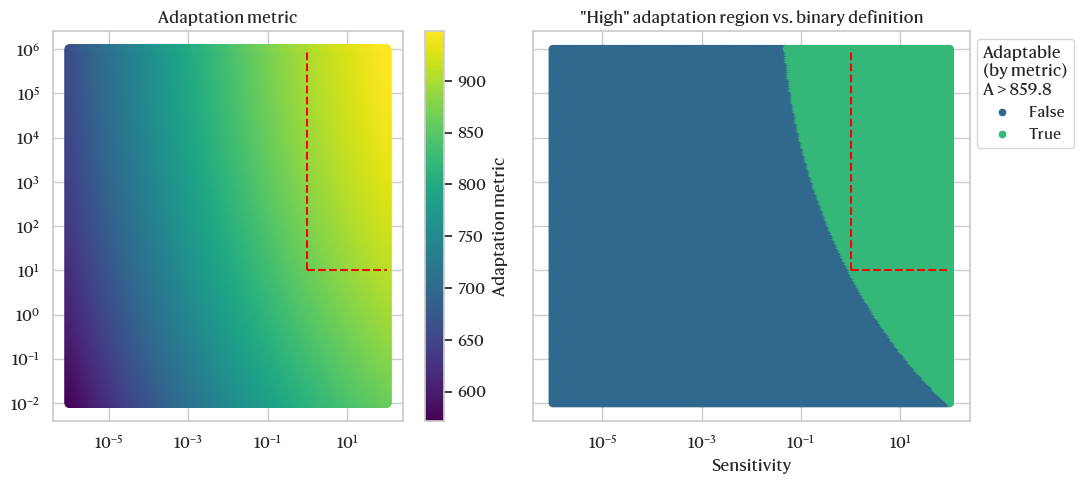

In [6]:
# Define ranges for variables 's' and 'p'
n_points = 201
s_values = np.linspace(-6, 2, n_points)
p_values = np.linspace(-2, 6, n_points)

# Create a meshgrid for plotting
S, P = np.meshgrid(s_values, p_values)

# Calculate adaptation metric 'a' for each (s, p) pair
A = calculate_adaptation(np.power(10, S), np.power(10, P), alpha=2)

df_s = pd.DataFrame({'Log sensitivity': S.flatten(),
                    'Log precision': P.flatten(), 'a': A.flatten()})
df_s['Adaptable'] = (df_s['Log sensitivity'] >= 0) & (
    df_s['Log precision'] >= 1)
min_adaptable = df_s[df_s['Adaptable']]['a'].min()
df_s['Pseudo_adaptable'] = df_s['a'] >= min_adaptable
df_s['Adaptability'] = False
df_s.loc[df_s['Pseudo_adaptable'] & df_s['Adaptable'], 'Adaptability'] = 'By binary metric'
df_s.loc[df_s['Pseudo_adaptable'] & ~df_s['Adaptable'], 'Adaptability'] = 'By continuous metric only'
df_s['Sensitivity'] = np.power(10, df_s['Log sensitivity'])
df_s['Precision'] = np.power(10, df_s['Log precision'])

fig, axs = plt.subplots(1, 2, figsize=(11, 5), sharex=True, sharey=True)
g = axs[0].scatter(data=df_s,
                   x='Sensitivity', y='Precision', c='a', cmap='viridis')
# g = sns.scatterplot(data=df_s,
#                 x='Sensitivity', y='Precision', hue='a', palette='viridis', legend=False, ax=axs[0])
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].vlines(*[10**i for i in [0, 1, 6]], colors='red', linestyles='dashed')
axs[0].hlines(*[10**i for i in [1, 0, 2]], colors='red', linestyles='dashed')
# axs[0].set_title('The adaptation metric (hue) smoothly maximises\nthe binary adaptation region (red dashed lines)')
axs[0].set_title('Adaptation metric')
plt.colorbar(g, ax=axs[0], label='Adaptation metric')

g = sns.scatterplot(data=df_s,
               x='Sensitivity', y='Precision',
            #    hue='Adaptability', palette='viridis', ax=axs[1], s=10) #, legend=False)
               hue='Pseudo_adaptable', palette='viridis', ax=axs[1]) #, legend=False)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1),
                title=f'Adaptable\n(by metric)\nA > {min_adaptable:.1f}')
axs[1].collections[0].set_edgecolors('none')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].vlines(*[10**i for i in [0, 1, 6]], colors='red', linestyles='dashed')
axs[1].hlines(*[10**i for i in [1, 0, 2]], colors='red', linestyles='dashed')
# axs[1].set_title('But some "high" adaptations (minimum of the\nbinary region) are not actually\nadaptable (green points outside boundary)')
axs[1].set_title('"High" adaptation region vs. binary definition')

plt.tight_layout()
plt.savefig(os.path.join(top_write_dir,
            'adaptation_metric_vs_binary_region.png'), dpi=300, bbox_inches='tight')

print('min_adaptable', min_adaptable)


In [4]:
print('Circuit that is adaptable (by metric) but not by binary definition:')
print(df_s[(df_s['Pseudo_adaptable']) & (~df_s['Adaptable'])].sort_values(
    by=['Log sensitivity', 'Log precision'], ascending=False).iloc[5:15])

Circuit that is adaptable (by metric) but not by binary definition:
       Log sensitivity  Log precision           a  Adaptable  \
14069              2.0           0.76  904.572388      False   
13868              2.0           0.72  904.031616      False   
13667              2.0           0.68  903.487610      False   
13466              2.0           0.64  902.940430      False   
13265              2.0           0.60  902.390015      False   
13064              2.0           0.56  901.836426      False   
12863              2.0           0.52  901.279602      False   
12662              2.0           0.48  900.719604      False   
12461              2.0           0.44  900.156372      False   
12260              2.0           0.40  899.589966      False   

       Pseudo_adaptable               Adaptability  Sensitivity  Precision  
14069              True  By continuous metric only        100.0   5.754399  
13868              True  By continuous metric only        100.0   5.24807

# Calculate adaptation metric: explanation

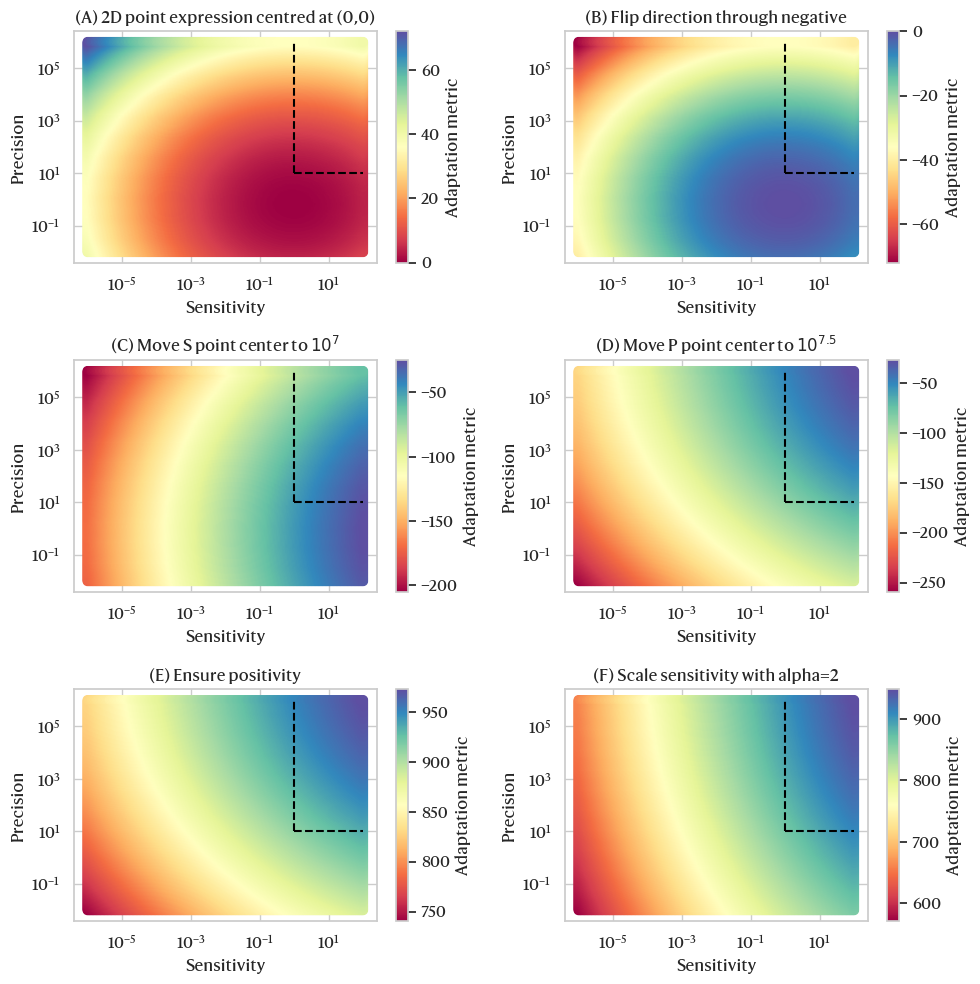

In [5]:
alpha = 2
s_center=0
p_center=0
# s_center=7
# p_center=7.5

f1 = lambda S, P, s_center, p_center: (S - s_center)**2 + (P - p_center)**2
f2 = lambda S, P, s_center, p_center: -((S - s_center)**2 + (P - p_center)**2) #+ 1000
f3 = lambda S, P, s_center, p_center: -(alpha*(S - s_center)**2 + (P - p_center)**2) #+ 1000
f4 = lambda S, P, s_center, p_center: -(alpha*(S - s_center)**2 + (P - p_center)**2) + 1000
f5 = lambda S, P, s_center, p_center: -((S - s_center)**2 + (P - p_center)**2) + 1000
a1 = f1(S, P, s_center, p_center)
a2 = f2(S, P, s_center, p_center)
s_center=7
a3 = f2(S, P, s_center, p_center)
p_center=7.5
a4 = f2(S, P, s_center, p_center)
a5 = f5(S, P, s_center, p_center)
a6 = f4(S, P, s_center, p_center)

fig, axs = plt.subplots(3,2, figsize=(10,10))

for ax, a, title in zip(axs.flatten(), [a1, a2, a3, a4, a5, a6], 
                        ['(A) 2D point expression centred at (0,0)', '(B) Flip direction through negative', 
                         '(C) Move S point center to $10^7$', '(D) Move P point center to $10^{7.5}$', 
                         '(E) Ensure positivity', '(F) Scale sensitivity with alpha=2']):
    sc = ax.scatter(np.power(10, S), np.power(10,P), c=a, cmap='Spectral')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Sensitivity')
    ax.set_ylabel('Precision')
    ax.vlines(*[10**i for i in [0, 1, 6]], colors='black', linestyles='dashed')
    ax.hlines(*[10**i for i in [1, 0, 2]], colors='black', linestyles='dashed')
    fig.colorbar(sc, ax=ax, label='Adaptation metric')
    ax.set_title(title)
plt.tight_layout()
plt.savefig(os.path.join(top_write_dir, 'adaptation_metric_construction.png'), dpi=300)